# 3-node summary

* Many plans are stalled @ yeast QQC, before the glycerol stock
* Some diploid definitions do not exist
* there may be some additional constructs to build 
* for yeast transformation failure, check age of miniprep

1. For yeast QC submission, there should be a way to search plans for subgraphs. You should also be able to force plans to submit subgraphs.
2. For diploid definitions, we whould be able to look at every combination of **A** and **alpha** and determine the topology and categorize (which circuit and whether there is a strain definition already).
3. Puppeteer plan???

In [3]:
from mysession import production
from pydent.planner import Planner
from pydent.browser import Browser

browser = Browser(production)

In [4]:
import arrow
utc = arrow.utcnow()
local = utc.to('US/Pacific')
date = local.format('YYYY-MM-DD')

In [5]:
my_yeast = browser.where({"user_id": 66}, sample_type="Yeast Strain")
print(len(my_yeast))

1114


In [6]:
my_yeast[-100].dump()

{'user_id': 66,
 'id': 27606,
 'data': None,
 'created_at': '2018-12-20T16:08:09.000-08:00',
 'sample_type_id': 5,
 'updated_at': '2018-12-20T16:08:09.000-08:00',
 'name': 'CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR2-Bleo-pGRR-W34W17-RGR-W19 | pMOD-LTR3-Hyg-pGRR-W19-RGR-W34 | pMOD6-pGRR-W19W5-RGR-W17 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALz4-RGR-W19 | pMOD6-pGRR-W34-yeGFP',
 'project': 'hysteresis',
 'description': '3-node bistable switch',
 'rid': 1015}

In [7]:
def filter_yeast_by_parts(parts_list):
    samples = browser.search(parts_list[0])
    found = []
    for sample in samples:
        if all([part in sample.name for part in parts_list]):
            found.append(sample)
    return found



found = filter_yeast_by_parts(["pMOD-LTR2-Bleo-pGRR-W20W10-RGR-W8", "pMOD8-pGRR-W8-RGR-W10", "pMOD-HOKan-pGRR-W8-RGR-W20"])
for s in found:
    print(s.description)

{"level": "3", "design": "g2", "total": 3}
3-node bistable switch
3-node bistable switch


Collect all yeast strains with a JSON description
Diploids have a non-JSON description with

In [8]:
import json

final_designs = []
designs = []
for yeast in my_yeast:
    try:
        description_json = json.loads(yeast.description)
    except:
        if "3-node" in yeast.description:
            final_designs.append(yeast)
        else:
            continue
    
    designs.append(yeast)
    
all_yeasts = final_designs + designs

In [9]:
def recursive_find_parents(yeasts, visited=None, depth=0, max_depth=10):
    print("DEPTH: {}".format(depth))
    print("NUM YEASTS: {}".format(len(yeasts)))
    print()
    if not yeasts:
        return []
    if visited is None:
        visited = set()
    if depth > max_depth:
        return yeasts
    yeasts = [y for y in yeasts if y and y.id not in visited]
    browser.recursive_retrieve(yeasts, {'field_values': 'sample'})
    visited = visited.union(set(y.id for y in yeasts))
    parents = []

    for y in yeasts:
        if 'Parent' in y.properties:
            parent = y.properties['Parent']
            if parent and parent not in parents:
                parents.append(parent)
        if y.properties['Mating Type'] == 'Diploid':
            haploids = y.properties['Haploids']
            for h in haploids:
                if h not in parents:
                    parents.append(h)
            
    yeasts += recursive_find_parents(parents, visited, depth+1, max_depth=max_depth)
    return yeasts

yeasts = recursive_find_parents(all_yeasts)

DEPTH: 0
NUM YEASTS: 467

DEPTH: 1
NUM YEASTS: 235

DEPTH: 2
NUM YEASTS: 4

DEPTH: 3
NUM YEASTS: 2

DEPTH: 4
NUM YEASTS: 0



In [10]:
yeasts[0].properties['Haploids']

[<pydent.models.Sample at 0xa23dc5240>, <pydent.models.Sample at 0xa23dc5360>]

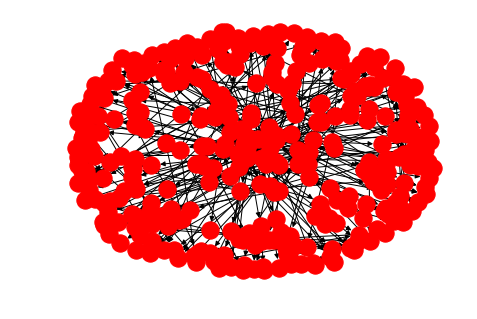

In [28]:
import networkx as nx
%matplotlib inline


g = nx.DiGraph()

edges = []
for yeast in yeasts:
    g.add_node(yeast.id, sample=yeast)
    parent = yeast.properties['Parent']
    if parent:
        g.add_node(parent.id, sample=parent)
        g.add_edge(parent.id, yeast.id)
        edges.append((parent.id, yeast.id))
    mating_type = yeast.properties['Mating Type']
    if mating_type:
        haploids = yeast.properties['Haploids']
        for h in haploids:
            g.add_node(h.id, sample=h)
            g.add_edge(h.id, yeast.id)

shortest_paths = list(nx.all_pairs_shortest_path(g))

nx.draw(g)

In [57]:
## collect items (run only once)
production.set_timeout(120)
items = browser.recursive_retrieve(yeasts, {"items": "object_type"})

items = []
for y in yeasts:
    for i in y.items:
        items.append(i)

browser.retrieve(items, "object_type")

## collect operations for each yeast (run only once)
# from tqdm import tqdm
# field_values = browser.where({"child_sample_id": [y.id for y in yeasts]}, model_class="FieldValue")
# ops = browser.recursive_retrieve(field_values, {'operation': 'operation_type'})
# from collections import defaultdict
# d = defaultdict(list)
# for fv in field_values:
#     d[fv.child_sample_id].append(fv.operation)
# for y in yeasts:
#     y.operations = d[y.id][:]


 54%|█████▍    | 195/361 [00:21<00:18,  9.18it/s]

In [68]:
production.set_verbose(True)

g.nodes[yeasts[0].id]['sample']

In [81]:
y = browser.find_by_name('design_module_0 | pMOD8-pGALZ4-URGR-W17')

2019-05-14 13:33:40,853 - AqHTTP@http://52.27.43.242/ - INFO - BODY: {'arguments': {'name': 'design_module_0 | pMOD8-pGALZ4-URGR-W17'},
 'method': 'where',
 'model': 'Sample',
 'options': {'limit': '-1', 'offset': '-1', 'reverse': 'False'}}


In [82]:
is_finished(y)

False

In [83]:
has_items(y)

[]

In [85]:
import pandas as pd

summary_rows = []
summary_dicts = []

def has_items(yeast):
    sample_items = [i for i in yeast.items if i.location != 'deleted']
    sample_items = [i for i in sample_items if not i.is_part]
    return sample_items
    
def is_finished(yeast):
    items = has_items(yeast)
    filtered = [i for i in items if i.object_type.name in ['Yeast Glycerol Stock', 'Yeast Competent Cell']]
    if filtered:
        return True
    return False   

def path_is_finished(g, nodes):
    finished_arr = []
    for n in nodes:
        sample = g.node[n]['sample']
        finished_arr.append(is_finished(sample))
    return all(finished_arr)


from tqdm import tqdm

for path in tqdm(shortest_paths, mininterval=3):
    source = path[0]
    destinations = list(path[1].keys())
    number_of_dependents = len(destinations)
    paths = path[1]
    
    paths = {k: v for k, v in paths.items() if len(v) > 1 and not path_is_finished(g, v)}
    if not paths:
        continue
    
    yeast_sample = g.node[source]["sample"]
    sample_items = has_items(yeast_sample)
    target_depths = [len(p) for p in paths.values()]
        
    
    row_dict = {
        "sample_name": yeast_sample.name,
        "sample_id": yeast_sample.id,
        "description": yeast_sample.description,
        "number_of_dependents": number_of_dependents,
        "target_depths": target_depths,
        "maximum_depth": max(target_depths),
        'finished': is_finished(yeast_sample),
        "targets": list(paths.keys()),
        "has_items": len(sample_items) > 0,
        "item_types": list(set([i.object_type.name for i in sample_items]))
    }
    summary_rows.append(row_dict)
    _row_dict = dict(row_dict)
    _row_dict.update({'yeast': yeast_sample})
    summary_dicts.append(_row_dict)
    
    
    
df = pd.DataFrame(summary_rows)
df.to_csv("3NodeSummary_{}.csv".format(date))




  0%|          | 0/361 [00:00<?, ?it/s]


100%|██████████| 361/361 [00:00<00:00, 969.05it/s]

## Get Remaining Progress for circuits

In [97]:
def leaves(g):
    l = []
    for n in g.nodes:
        if not list(g.successors(n)):
            l.append(n)
    return l

def roots(g):
    r = []
    for n in g.nodes:
        if not list(g.predecessors(n)):
            r.append(n)
    return r



(27544, {27544: [27544]})

In [100]:
g.node[shortest_paths[0][0]]['sample'].name

'CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-HOKan-pGRR-W20-RGR-W34 | pMOD6-leu-pGRR-W5W34-RGR-W20 | pMOD6-pGRR-W20-RGR-W5 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W20 | pMOD6-pGRR-W34-yeGFP'

In [112]:
# _g = nx.bfs_tree(g, shortest_paths[2][0])
# nx.draw(_g)
rg = g.reverse()

In [113]:
leaf_nodes = leaves(g)

In [157]:
def progress_summary(g):
    leaf_nodes = leaves(g)
    
    summary_arr = []
    
    for lf in leaf_nodes:
        _g = nx.bfs_tree(g, lf, reverse=True)
        nodes = list(_g.nodes())

        node_colors = []
        percent_complete = 0
        for n in nodes:
            sample = g.node[n]['sample']
            if is_finished(sample):
                node_colors.append('blue')
                percent_complete += 100./len(nodes)
            else:
                node_colors.append('red')
        summary_arr.append((lf, percent_complete))
    return sorted(summary_arr, key=lambda x: x[1])

summary = progress_summary(g)
summary = [x for x in summary if g.node[x[0]]['sample'].properties['Mating Type'] == 'Diploid']
# summary = [x for x in summary if x[1] >= 80]
summary
#         nx.draw(_g.reverse(), node_color=node_colors)

[(27556, 50.0),
 (27557, 50.0),
 (27561, 50.0),
 (27565, 50.0),
 (27544, 60.0),
 (27545, 60.0),
 (27550, 60.0),
 (27552, 60.0),
 (27554, 60.0),
 (27563, 60.0),
 (27566, 60.0),
 (27568, 60.0),
 (27570, 60.0),
 (27572, 60.0),
 (27616, 60.0),
 (27648, 60.0),
 (27649, 60.0),
 (27650, 60.0),
 (27652, 60.0),
 (27653, 60.0),
 (27654, 60.0),
 (27655, 60.0),
 (27656, 60.0),
 (27657, 60.0),
 (27658, 60.0),
 (27659, 60.0),
 (27661, 60.0),
 (27662, 60.0),
 (27663, 60.0),
 (27664, 60.0),
 (27665, 60.0),
 (27666, 60.0),
 (27667, 60.0),
 (27668, 60.0),
 (27670, 60.0),
 (27672, 60.0),
 (27546, 70.0),
 (27547, 70.0),
 (27548, 70.0),
 (27549, 70.0),
 (27551, 70.0),
 (27558, 70.0),
 (27571, 70.0),
 (27573, 70.0),
 (27581, 70.0),
 (27582, 70.0),
 (27586, 70.0),
 (27588, 70.0),
 (27596, 70.0),
 (27597, 70.0),
 (27599, 70.0),
 (27605, 70.0),
 (27606, 70.0),
 (27607, 70.0),
 (27610, 70.0),
 (27611, 70.0),
 (27612, 70.0),
 (27613, 70.0),
 (27614, 70.0),
 (27619, 70.0),
 (27622, 70.0),
 (27623, 70.0),
 (27624,

In [190]:
from copy import deepcopy

def to_undirected(graph):
    """.to_undirected is implemented in networkx out of the box, however, it
    suffers from occational infinite recursion errors during the deepcopy phase
    of the method (unknown as to why). """
    undirected = nx.Graph()
    copied = deepcopy(graph)
    for n in copied.nodes:
        ndata = copied.node[n]
        undirected.add_node(n, **ndata)
    for n1, n2 in copied.edges:
        edata = copied.edges[n1, n2]
        undirected.add_edge(n1, n2, **edata)
    return undirected


def get_subgraphs(graph, node_list=None):
    """Get independent subgraphs"""
    if node_list is None:
        node_list = list(graph.nodes)
    subgraphs = []
    while len(node_list) > 0:
        node = node_list[-1]
        subgraph = nx.bfs_tree(to_undirected(graph), node)
        for n in subgraph.nodes:
            if n in node_list:
                node_list.remove(n)
        subgraphs.append(graph.subgraph(subgraph.nodes))
    return subgraphs


unfinished_graph = g.subgraph([n for n in _g.nodes if not is_finished(g.node[n]['sample'])])
graphs = get_subgraphs(unfinished_graph, [n for n, p in summary if n in unfinished_graph and p >=80])

These are all of the samples that are very close (>80%) to being completed. Root nodes have a parent that has a yeast glycerol stock. Iterate through this graph using Terrarium to plan these strains.

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-NatMx-pGRR-W5-RGR-W19 | pMOD6-pGRR-W19W5-RGR-W17 | pMOD8-pGRR-W19W17-RGR-W5 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W5 | pMOD6-pGRR-W19-yeGFP


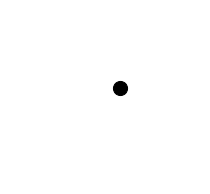

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-Nat-pGRR-W5W8-URGR-F1 | pMOD-LTR2-Bleo-pGRR-F1W10-RGR-W8 | pMOD8-pGRR-W8-RGR-W10
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-Nat-pGRR-W5W8-URGR-F1 | pMOD-LTR2-Bleo-pGRR-F1W10-RGR-W8 | pMOD8-pGRR-W8-RGR-W10 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W8 | pMOD6-pGRR-F1-yeGFP
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-Nat-pGRR-W5W8-URGR-F1 | pMOD-LTR2-Bleo-pGRR-F1W10-RGR-W8 | pMOD8-pGRR-W8-RGR-W10 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-RGR-W8 | pMOD6-pGRR-F1-yeGFP


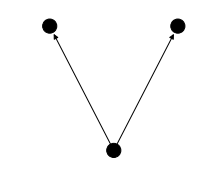

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-HOKan-pGRR-W8W36-RGR-W20 | pMOD-LTR2-Bleo-pGRR-W20W8-RGR-W36 | pMOD6-pGRR-W36-RGR-W8 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W36 | pMOD6-pGRR-W8-yeGFP
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-HOKan-pGRR-W8W36-RGR-W20 | pMOD-LTR2-Bleo-pGRR-W20W8-RGR-W36 | pMOD6-pGRR-W36-RGR-W8


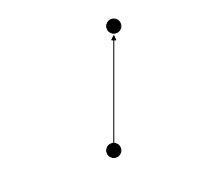

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-HOKan-pGRR-W36W8-RGR-W20 | pMOD-LTR2-Bleo-pGRR-W20W8-RGR-W36 | pMOD6-pGRR-W36-RGR-W8 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W36 | pMOD6-pGRR-W8-yeGFP
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-HOKan-pGRR-W36W8-RGR-W20 | pMOD-LTR2-Bleo-pGRR-W20W8-RGR-W36 | pMOD6-pGRR-W36-RGR-W8


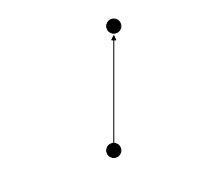

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-HO-Leu2-pGRR-W8W36-RGR-W20 | pMOD-LTR2-Bleo-pGRR-W20W8-RGR-W36 | pMOD6-pGRR-W36-RGR-W8
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-HO-Leu2-pGRR-W8W36-RGR-W20 | pMOD-LTR2-Bleo-pGRR-W20W8-RGR-W36 | pMOD6-pGRR-W36-RGR-W8 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W36 | pMOD6-pGRR-W8-yeGFP


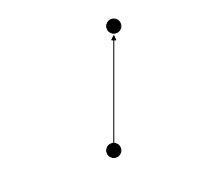

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR2-Bleo-pGRR-W34W17-RGR-W19 | pMOD6-pGRR-W5W19-RGR-W17 | pMOD8-pGRR-W19W17-RGR-W5
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR2-Bleo-pGRR-W34W17-RGR-W19 | pMOD6-pGRR-W5W19-RGR-W17 | pMOD8-pGRR-W19W17-RGR-W5 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W17 | pMOD6-pGRR-W19-yeGFP


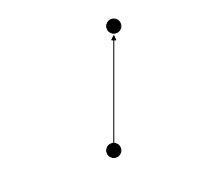

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-NatMx-pGRR-W5-RGR-W19 | pMOD6-pGRR-W5W19-RGR-W17 | pMOD8-pGRR-W19W17-RGR-W5
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-NatMx-pGRR-W5-RGR-W19 | pMOD6-pGRR-W5W19-RGR-W17 | pMOD8-pGRR-W19W17-RGR-W5 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W5 | pMOD6-pGRR-W19-yeGFP


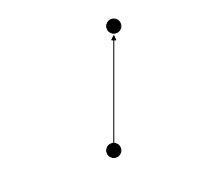

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-HOKan-pGRR-W8-RGR-W20 | pMOD-LTR1-NatMX-pGRR-W8-RGR-W10 | pMOD-LTR2-Bleo-pGRR-W20W10-RGR-W8 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-RGR-W8 | pMOD6-pGRR-W20-yeGFP
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-HOKan-pGRR-W8-RGR-W20 | pMOD-LTR1-NatMX-pGRR-W8-RGR-W10 | pMOD-LTR2-Bleo-pGRR-W20W10-RGR-W8
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-HOKan-pGRR-W8-RGR-W20 | pMOD-LTR1-NatMX-pGRR-W8-RGR-W10 | pMOD-LTR2-Bleo-pGRR-W20W10-RGR-W8 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W8 | pMOD6-pGRR-W20-yeGFP


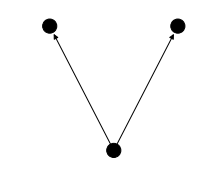

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-HOKan-pGRR-W8W36-RGR-W20 | pMOD-LTR1-NatMX-pGRR-W8-RGR-W10 | pMOD-LTR2-Bleo-pGRR-W20W10-RGR-W8 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W8 | pMOD6-pGRR-W20-yeGFP
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-HOKan-pGRR-W8W36-RGR-W20 | pMOD-LTR1-NatMX-pGRR-W8-RGR-W10 | pMOD-LTR2-Bleo-pGRR-W20W10-RGR-W8
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-HOKan-pGRR-W8W36-RGR-W20 | pMOD-LTR1-NatMX-pGRR-W8-RGR-W10 | pMOD-LTR2-Bleo-pGRR-W20W10-RGR-W8 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-RGR-W8 | pMOD6-pGRR-W20-yeGFP


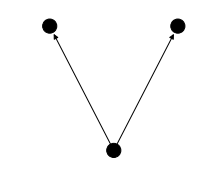

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-Nat-pGRR-W36-RGR-W8 | pMOD-LTR2-Bleo-pGRR-W20W8-RGR-W36 | pMOD6-pGRR-W36-RGR-W20 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W36 | pMOD6-pGRR-W20-yeGFP
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-Nat-pGRR-W36-RGR-W8 | pMOD-LTR2-Bleo-pGRR-W20W8-RGR-W36 | pMOD6-pGRR-W36-RGR-W20


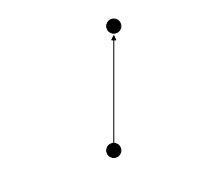

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-Nat-pGRR-W19-RGR-W34 | pMOD-LTR2-Bleo-pGRR-W34W17-RGR-W19 | pMOD8-pGRR-W19-RGR-W17 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALz4-RGR-W19 | pMOD6-pGRR-W34-yeGFP
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-Nat-pGRR-W19-RGR-W34 | pMOD-LTR2-Bleo-pGRR-W34W17-RGR-W19 | pMOD8-pGRR-W19-RGR-W17


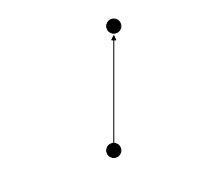

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-Kanmx-pGRR-W19-RGR-W34 | pMOD-LTR2-Bleo-pGRR-W34W17-RGR-W19 | pMOD8-pGRR-W19-RGR-W17 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALz4-RGR-W19 | pMOD6-pGRR-W34-yeGFP
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-Kanmx-pGRR-W19-RGR-W34 | pMOD-LTR2-Bleo-pGRR-W34W17-RGR-W19 | pMOD8-pGRR-W19-RGR-W17


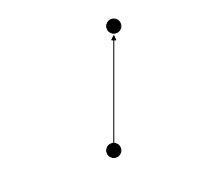

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR2-Bleo-pGRR-W34W17-RGR-W19 | pMOD-LTR3-Kanmx-pGRR-W19-RGR-W34 | pMOD8-pGRR-W19-RGR-W17 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALz4-RGR-W19 | pMOD6-pGRR-W34-yeGFP
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR2-Bleo-pGRR-W34W17-RGR-W19 | pMOD-LTR3-Kanmx-pGRR-W19-RGR-W34 | pMOD8-pGRR-W19-RGR-W17


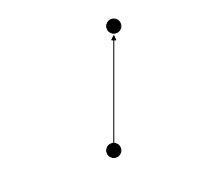

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR2-Bleo-pGRR-W34W17-RGR-W19 | pMOD-LTR3-Kanmx-pGRR-W19-RGR-W34 | pMOD6-pGRR-W5W19-RGR-W17
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR2-Bleo-pGRR-W34W17-RGR-W19 | pMOD-LTR3-Kanmx-pGRR-W19-RGR-W34 | pMOD6-pGRR-W5W19-RGR-W17 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALz4-RGR-W19 | pMOD6-pGRR-W34-yeGFP


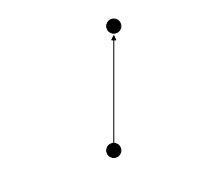

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-NatMx-pGRR-W5-RGR-W19 | pMOD-LTR3-bleo-pGRR-W19W17-RGR-W5 | pMOD6-pGRR-W5-RGR-W17
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-NatMx-pGRR-W5-RGR-W19 | pMOD-LTR3-bleo-pGRR-W19W17-RGR-W5 | pMOD6-pGRR-W5-RGR-W17 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W5 | pMOD6-pGRR-W17-yeGFP


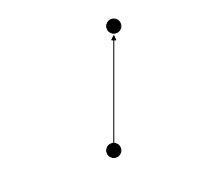

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-NatMx-pGRR-W5-RGR-W19 | pMOD-LTR3-bleo-pGRR-W19W17-RGR-W5 | pMOD6-pGRR-W5W34-RGR-W17 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W5 | pMOD6-pGRR-W17-yeGFP
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-NatMx-pGRR-W5-RGR-W19 | pMOD-LTR3-bleo-pGRR-W19W17-RGR-W5 | pMOD6-pGRR-W5W34-RGR-W17


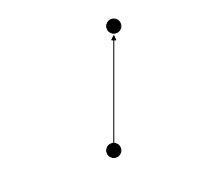

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-NatMx-pGRR-W5-RGR-W19 | pMOD-LTR3-bleo-pGRR-W19W17-RGR-W5 | pMOD6-pGRR-F10W5-RGR-W17 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W5 | pMOD6-pGRR-W17-yeGFP
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-NatMx-pGRR-W5-RGR-W19 | pMOD-LTR3-bleo-pGRR-W19W17-RGR-W5 | pMOD6-pGRR-F10W5-RGR-W17


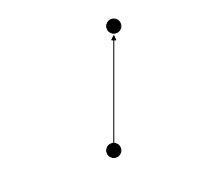

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-NatMx-pGRR-W5-RGR-W19 | pMOD-LTR3-bleo-pGRR-W19W17-RGR-W5 | pMOD6-pGRR-F7W5-RGR-W17 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W5 | pMOD6-pGRR-W17-yeGFP
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-NatMx-pGRR-W5-RGR-W19 | pMOD-LTR3-bleo-pGRR-W19W17-RGR-W5 | pMOD6-pGRR-F7W5-RGR-W17


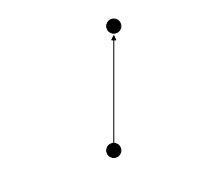

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-NatMx-pGRR-W5-RGR-W19 | pMOD-LTR3-bleo-pGRR-W19W17-RGR-W5 | pMOD6-pGRR-F6W5-RGR-W17
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-NatMx-pGRR-W5-RGR-W19 | pMOD-LTR3-bleo-pGRR-W19W17-RGR-W5 | pMOD6-pGRR-F6W5-RGR-W17 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W5 | pMOD6-pGRR-W17-yeGFP


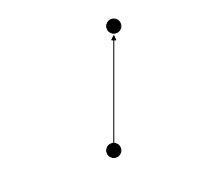

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-NatMx-pGRR-W5-RGR-W19 | pMOD-LTR3-bleo-pGRR-W19W17-RGR-W5 | pMOD6-pGRR-F4W5-RGR-W17 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W5 | pMOD6-pGRR-W17-yeGFP
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-NatMx-pGRR-W5-RGR-W19 | pMOD-LTR3-bleo-pGRR-W19W17-RGR-W5 | pMOD6-pGRR-F4W5-RGR-W17


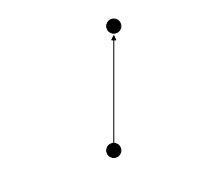

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-HOKan-pGRR-W17-RGR-W5 | pMOD-LTR3-bleo-pGRR-W19W17-RGR-W34 | pMOD6-pGRR-W5W34-RGR-W17
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-HOKan-pGRR-W17-RGR-W5 | pMOD-LTR3-bleo-pGRR-W19W17-RGR-W34 | pMOD6-pGRR-W5W34-RGR-W17 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W17 | pMOD6-pGRR-W34-yeGFP


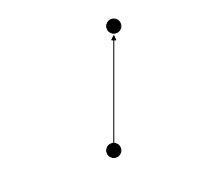

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-HOKan-pGRR-W17-RGR-W5 | pMOD-LTR1-Nat-pGRR-W17-RGR-W34 | pMOD6-pGRR-W5W34-RGR-W17 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W17 | pMOD6-pGRR-W34-yeGFP
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-HOKan-pGRR-W17-RGR-W5 | pMOD-LTR1-Nat-pGRR-W17-RGR-W34 | pMOD6-pGRR-W5W34-RGR-W17


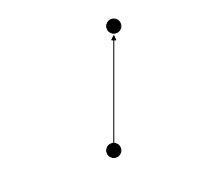

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-HOKan-pGRR-W17-RGR-W34 | pMOD-LTR3-bleo-pGRR-W19W17-RGR-W5 | pMOD6-pGRR-W5W34-RGR-W17 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W17 | pMOD6-pGRR-W34-yeGFP
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-HOKan-pGRR-W17-RGR-W34 | pMOD-LTR3-bleo-pGRR-W19W17-RGR-W5 | pMOD6-pGRR-W5W34-RGR-W17


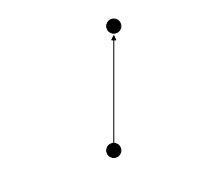

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-Nat-pGRR-W17-RGR-W34 | pMOD6-pGRR-W5W34-RGR-W17 | pMOD8-pGRR-W19W17-RGR-W5 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W17 | pMOD6-pGRR-W5-yeGFP
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-Nat-pGRR-W17-RGR-W34 | pMOD6-pGRR-W5W34-RGR-W17 | pMOD8-pGRR-W19W17-RGR-W5


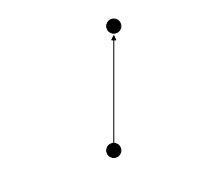

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR3-bleo-pGRR-W19W17-RGR-W34 | pMOD6-pGRR-W5W34-RGR-W17 | pMOD8-pGRR-W19W17-RGR-W5
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR3-bleo-pGRR-W19W17-RGR-W34 | pMOD6-pGRR-W5W34-RGR-W17 | pMOD8-pGRR-W19W17-RGR-W5 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W17 | pMOD6-pGRR-W5-yeGFP


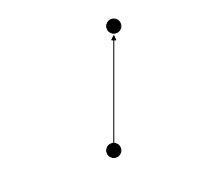

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-HOKan-pGRR-W17-RGR-W5 | pMOD-LTR2-Bleo-pGRR-W17W17-RGR-W19 | pMOD6-pGRR-W5W19-RGR-W17
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-HOKan-pGRR-W17-RGR-W5 | pMOD-LTR2-Bleo-pGRR-W17W17-RGR-W19 | pMOD6-pGRR-W5W19-RGR-W17 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W17 | pMOD6-pGRR-W5-yeGFP


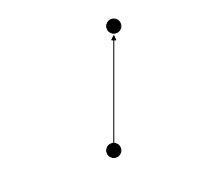

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-HOKan-pGRR-W17-RGR-W5 | pMOD-LTR2-Bleo-pGRR-W34W17-RGR-W19 | pMOD6-pGRR-W5W19-RGR-W17 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W17 | pMOD6-pGRR-W5-yeGFP
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-HOKan-pGRR-W17-RGR-W5 | pMOD-LTR2-Bleo-pGRR-W34W17-RGR-W19 | pMOD6-pGRR-W5W19-RGR-W17


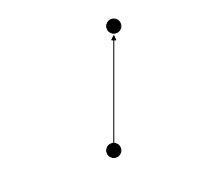

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR3-Hyg-pGRR-W17-RGR-W34 | pMOD-LTR3-bleo-pGRR-W19W17-RGR-W5 | pMOD6-pGRR-W5W34-RGR-W17 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W17 | pMOD6-pGRR-W5-yeGFP
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR3-Hyg-pGRR-W17-RGR-W34 | pMOD-LTR3-bleo-pGRR-W19W17-RGR-W5 | pMOD6-pGRR-W5W34-RGR-W17


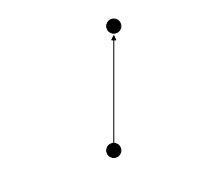

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-Nat-pGRR-W17-RGR-W34 | pMOD-LTR3-bleo-pGRR-W19W17-RGR-W5 | pMOD6-pGRR-W5W34-RGR-W17
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-Nat-pGRR-W17-RGR-W34 | pMOD-LTR3-bleo-pGRR-W19W17-RGR-W5 | pMOD6-pGRR-W5W34-RGR-W17 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W17 | pMOD6-pGRR-W5-yeGFP


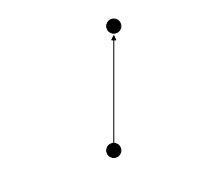

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-NatMx-pGRR-W5-RGR-W19 | pMOD-LTR3-bleo-pGRR-W19W8-RGR-W5 | pMOD6-pGRR-W5-RGR-W8 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W5 | pMOD6-pGRR-W8-yeGFP
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-NatMx-pGRR-W5-RGR-W19 | pMOD-LTR3-bleo-pGRR-W19W8-RGR-W5 | pMOD6-pGRR-W5-RGR-W8


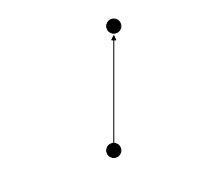

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-Nat-pGRR-W20-RGR-W34 | pMOD-LTR2-Bleo-pGRR-W20W8-RGR-W5 | pMOD6-leu-pGRR-W5W34-RGR-W20 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W20 | pMOD6-pGRR-W34-yeGFP
CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-Nat-pGRR-W20-RGR-W34 | pMOD-LTR2-Bleo-pGRR-W20W8-RGR-W5 | pMOD6-leu-pGRR-W5W34-RGR-W20


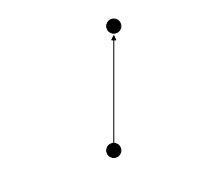

In [196]:
for _g in graphs:
    _g = _g.subgraph([n for n in _g.nodes if not is_finished(g.node[n]['sample'])])
    ax = plt.figure(figsize=(3,3)).gca()
    ax.axis('off')
    for n in _g.nodes:
        print(_g.node[n]['sample'].name)
    plotter = GraphPlotter(_g, ax=ax)
    plotter.topological_sort()
    plotter.draw_graph(node_color=(0, 0, 0))
    plt.show()

In [150]:
r = roots(_g)
r

[27417,
 27555,
 27400,
 27560,
 27564,
 27427,
 27488,
 27484,
 27482,
 27480,
 27442,
 27439,
 27486,
 27478,
 27474,
 27471,
 27470,
 27469,
 27468,
 27467,
 27466,
 27464,
 27463,
 27461,
 27449,
 27462,
 27609,
 27460,
 27458,
 27451,
 27450,
 27422,
 27405,
 27389,
 27647,
 27338,
 27677,
 27346,
 27344,
 27341,
 27331,
 27327,
 27319,
 27369,
 27323,
 27339,
 27347,
 27356,
 27359,
 27361,
 27363,
 27365,
 27374,
 27377,
 27380,
 27393,
 27395,
 27401,
 27406,
 27409,
 27412,
 27423,
 27429,
 27432,
 27435,
 27443,
 27445,
 27452,
 27475,
 27492,
 27494,
 27497,
 27501,
 27504,
 27510,
 27513]

In [142]:
#@title Graph Plotter

import collections
import numpy as np
import networkx as nx
import pylab as plt
%matplotlib inline

def sorted_center(iterable, reverse=False, key=None, select=None):
    centered = []
    s = sorted(iterable, key=key, reverse=reverse)
    front = False
    for v in s:
        if not front:
            centered.append(v)
        else:
            centered.insert(0, v)
        front = not front
    if select:
        return [select(_x) for _x in centered]
    return centered

class GraphPlotter(object):
  
  def __init__(self, graph, ax=None, pos=None):
    if ax is None:
      ax = plt.figure(figsize=(3,3)).gca()
      ax.axis('off')
      ax.set_xlim(0, 1.0)
      ax.set_ylim(0, 1.0)
    
    self._ax = ax
    self._graph = graph
    if pos is None:
      self._pos = dict()
      self.spring_layout()
    else:
      self._pos = pos
      
  @property
  def _base_draw_kwargs(self):
    return dict(G=self._graph, ax=self._ax, pos=self._pos)
 
  def topological_sort(self):
    xlim = self._ax.get_xlim()
    ylim = self._ax.get_ylim()
    
    x = xlim[1] - xlim[0]
    y = ylim[1] - ylim[0]
    xspacer = x * 0.05
    yspacer = y * 0.05
    
    new_xlim = (xlim[0] + xspacer, xlim[1] - xspacer)
    new_ylim = (ylim[0] + yspacer, ylim[1] - yspacer)
    pos = self._topological_sort(self._graph, 
                                 xlim=new_xlim, 
                                 ylim=new_ylim)
    self._pos = pos

  @staticmethod
  def _roots_and_leaves(G, include_cycles=False):
    roots = [k for k, v in G.in_degree(G.nodes) if v == 0]
    leaves = [k for k, v in G.out_degree(G.nodes) if v == 0]
    
    if include_cycles:
      for c in nx.simple_cycles(G):
        outdegree = list(G.out_degree(c))
        outdegree.sort(key=lambda x: x[1])
        leaves.append(outdegree[0][0])

        indegree = list(G.out_degree(c))
        indegree.sort(key=lambda x: x[1])
        roots.append(indegree[0][0])
    return roots, leaves
  
  @classmethod
  def _get_roots(cls, G, include_cycles=False):
    return cls._roots_and_leaves(G, include_cycles=include_cycles)[0]

  @staticmethod
  def _get_leaves(G, include_cycles=False):
    return cls._roots_and_leaves(G, include_cycles=include_cycles)[1]

  @staticmethod
  def _get_subgraphs(graph):
    """Get independent subgraphs"""
    node_list = list(graph.nodes)
    subgraphs = []
    while len(node_list) > 0:
        node = node_list[-1]
        subgraph = nx.bfs_tree(to_undirected(graph), node)
        for n in subgraph.nodes:
            node_list.remove(n)
        subgraphs.append(graph.subgraph(subgraph.nodes))
    return subgraphs

  @classmethod
  def _topological_sort(cls, G, xlim=None, ylim=None):
    if xlim is None:
        xlim = [0.05, 0.95]
    if ylim is None:
        ylim = [0.05, 0.95]
    
    rts = cls._get_roots(G, include_cycles=True)
    max_depth = {}
    for root in rts:
        depths = nx.single_source_shortest_path_length(G, root)
        for n, d in depths.items():
            max_depth[n] = max(max_depth.get(n, d), d)

    by_depth = collections.OrderedDict()

    for node, depth in max_depth.items():
        by_depth.setdefault(depth, [])
        by_depth[depth].append(node)
    
    # center nodes with highest degree
    for depth, nodes in by_depth.items():
        centered = sorted_center(list(G.degree(nodes)), 
                                 key=lambda x: x[1], 
                                 reverse=True,
                                select=lambda x: x[0])
        by_depth[depth] = centered

    # push roots 'up' so they are not stuck on layer one
    for root in rts:
        successors = list(G.successors(root))
        if len(successors) > 0:
            min_depth = min([max_depth[s] for s in successors])
            max_depth[root] = min_depth - 1

    # assign positions

    y_min_max = xlim
    x_min_max = ylim
    max_width = max([len(layer) for layer in by_depth.values()])

    y_step = (y_min_max[1] - y_min_max[0]) / (max(by_depth.keys())+1)
    x_step = (x_min_max[1] - x_min_max[0]) / (max_width )
    positions = {}

    for depth in sorted(by_depth):
        y = y_step * depth + y_min_max[0]
        node_ids = by_depth[depth]
        w = len(node_ids)
        delta_w = max_width - w
        for i, n in enumerate(node_ids):
            x_offset = delta_w * x_step / 2.0
            x = x_min_max[0] + x_offset + i * x_step
            positions[n] = (x, y)
    return positions

  def spring_layout(self, **kwargs):
    pos = nx.spring_layout(self._graph, **kwargs)
    self._pos.update(pos)
    return self._pos
    
  @property
  def nodes(self):
    return self._graph.nodes
  
  @property
  def edges(self):
    return self._graph.edges
  
  def node_attrs(self):
    keys = set()
    for _, node_data in self._graph.nodes(data=True):
      keys.update(set(node_data.keys()))
    attrs = {}
    for _, node_data in self._graph.nodes(data=True):
      for k in keys:
        attrs.setdefault(k, list())
        attrs[k].append(node_data.get(k, None))
    return attrs
  
  def edge_attrs(self):
    keys = set()
    for _, _, edge_data in self._graph.edges(data=True):
      keys.update(set(edge_data.keys()))
    attrs = {}
    for _, _, edge_data in self._graph.edges(data=True):
      for k in keys:
        attrs.setdefault(k, list())
        attrs[k].append(edge_data.get(k, None))
    return attrs
  
  def map_edge_attrs(self, attrs, source, target):
    vals = [self._normalize(self.edge_attrs()[attr], source, target) for attr in attrs]
    return dict(zip(attrs, vals))
  
  def map_node_attrs(self, attrs, source, target):
    vals = [self._normalize(self.node_attrs()[attr], source, target) for attr in attrs]
    return dict(zip(attrs, vals))
  
  def _normalize(arr, source, target):
    x = source[1] - source[0]
    y = target[1] - target[0]
    return [_x/x * y + target[0] for _x in arr] 
  
  def _make_draw_kwargs(self, **kwargs):
    kwargs.update(self._base_draw_kwargs)
    return kwargs
  
  def _draw(self, draw_function, zorder=None, **kwargs):
    draw_kwargs = self._make_draw_kwargs(**kwargs)
    collection = draw_function(**draw_kwargs)
    if collection is not None and zorder is not None:
      try:
        # This is for compatibility with older matplotlib.
        collection.set_zorder(zorder)
      except AttributeError:
        # This is for compatibility with newer matplotlib.
        collection[0].set_zorder(zorder)
    return collection

  def draw_nodes(self, **kwargs):
    """Useful kwargs: nodelist, node_size, node_color, linewidths."""
    if ("node_color" in kwargs and
        isinstance(kwargs["node_color"], collections.Sequence) and
        len(kwargs["node_color"]) in {3, 4} and
        not isinstance(kwargs["node_color"][0],
                       (collections.Sequence, np.ndarray))):
      num_nodes = len(kwargs.get("nodelist", self.nodes))
      kwargs["node_color"] = np.tile(
          np.array(kwargs["node_color"])[None], [num_nodes, 1])
    return self._draw(nx.draw_networkx_nodes, **kwargs)

  def draw_edges(self, **kwargs):
    """Useful kwargs: edgelist, width."""
    return self._draw(nx.draw_networkx_edges, **kwargs)
  
  def draw_graph(self,
                 node_size=200,
                 node_color=(0.4, 0.8, 0.4),
                 node_linewidth=1.0,
                 edge_width=1.0):
    
    node_border_color = (0.0, 0.0, 0.0, 1.0)
    
    # Plot nodes.
    self.draw_nodes(
        nodelist=self.nodes,
        node_size=node_size,
        node_color=node_color,
        linewidths=node_linewidth,
        edgecolors=node_border_color,
        zorder=20)
    # Plot edges.
    self.draw_edges(edgelist=self.edges, width=edge_width, zorder=10)

60.0


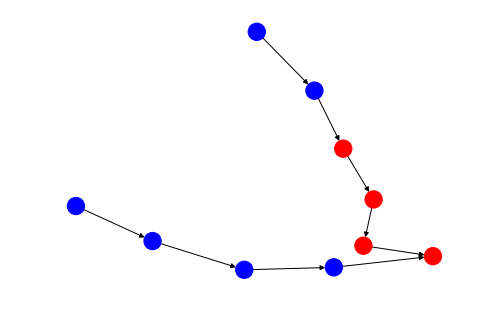

In [127]:
_g = nx.bfs_tree(rg, leaf_nodes[1])
nodes = list(_g.nodes())

node_colors = []
percent_complete = 0
for n in nodes:
    sample = g.node[n]['sample']
    if is_finished(sample):
        node_colors.append('blue')
        percent_complete += 100./len(nodes)
    else:
        node_colors.append('red')
print(percent_complete)
nx.draw(_g.reverse(), node_color=node_colors)

In [13]:
has_glycerol_stocks = [y for y in yeasts if "Yeast Glycerol Stock" in [i.object_type.name for i in y.items]]
has_yeast_plate = [y for y in yeasts if "Yeast Plate" in [i.object_type.name for i in y.items] or "Yeast Glycerol Stock" in [i.object_type.name for i in y.items]]

print(len(has_glycerol_stocks))
print(len(has_yeast_plate))
print(len(yeasts))

103
131
483


In [14]:
ready_for_mating = []

for row in summary_dicts:
    y = row['yeast']
    if row['maximum_depth'] <= 2 and row['has_items'] and y.properties['Mating Type'].lower() == "mata":
        print(y.name)
        print(row['item_types'])
        print("Targets:")
        for t in row['targets'][1:]:
            print('', end='\t')
            print(t)
        print()

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-NatMx-pGRR-W5-RGR-W19 | pMOD-LTR3-bleo-pGRR-W19W8-RGR-W5 | pMOD6-pGRR-W5-RGR-W8
['__Part']
Targets:
	CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR1-NatMx-pGRR-W5-RGR-W19 | pMOD-LTR3-bleo-pGRR-W19W8-RGR-W5 | pMOD6-pGRR-W5-RGR-W8 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W5 | pMOD6-pGRR-W8-yeGFP

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR3-Hyg-pGRR-W17-RGR-W34 | pMOD6-pGRR-W5W34-RGR-W17 | pMOD8-pGRR-W19W17-RGR-W5
['__Part']
Targets:
	CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-LTR3-Hyg-pGRR-W17-RGR-W34 | pMOD6-pGRR-W5W34-RGR-W17 | pMOD8-pGRR-W19W17-RGR-W5 _X_ CEN.PK2 - MAT alpha ::: pMODKan-HO-pACT1-ZEV4 | pMOD8-pGALZ4-URGR-W17 | pMOD6-pGRR-W5-yeGFP

CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-HOKan-pGRR-W17-RGR-W20 | pMOD-LTR1-Nat-pGRR-W5W20-RGR-W17 | pMOD8-pGRR-W19W17-RGR-W5
['__Part']
Targets:
	CEN.PK2 - MAT A ::: pMOD4G-dcas9-mxi1 | pMOD-HOKan-pGRR-W17-RGR-W20 | pMOD-LTR1-Nat-pGRR-W5W20-RGR-W17 |

In [15]:
field_values = []
for y in yeasts:
    item_types = [i.object_type.name for i in y.items]
    if 'Yeast Glycerol Stock' not in item_types and 'Yeast Plate' in item_types:
        yeast_plates = [i for i in y.items if i.object_type.name == 'Yeast Plate']
        fvs = browser.where({"child_item_id": [y.id for y in yeast_plates], "role": "output"}, model_class="FieldValue")
        field_values += fvs
        


**Collect all designs**
* name
* description
* sample id
* parts list
* is an intermediate strain?
* end goal sample
* design topology (G1, G2, B)
* diploid
* item progress (yeast glycerol stock, plate, failures?)

**To Be End Goal, must be diploid, have a GFP and have Mxi1**

**Yeast Progress**

1. find plan
2. find operations with yeast sample
3. report status of latest

In [16]:
import pandas as pd

df = pd.read_csv("valid_3node_circuits.csv")
len(list(df.groupby("design")))

FileNotFoundError: [Errno 2] File b'valid_3node_circuits.csv' does not exist: b'valid_3node_circuits.csv'

# Make Diploid Strains

In [33]:
alpha_strains = [y for y in yeasts if 'alpha' in y.properties['Mating Type'] and 'GFP' in y.name]
diploids = []

for alpha in alpha_strains:
    data = json.loads(alpha.description)
    a_strain_ids = data['a_strains']
    a_strains = browser.find(a_strain_ids)
    
    for a in a_strains:
        new_yeast = ' _X_ '.join([a.name, alpha.name])
        diploids.append(new_yeast)

In [34]:
for dname in diploids:
    sample = browser.find_by_name(dname)
    if not sample:
        print(dname)
    else:
        print("found")

found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
